In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.formula.api import ols
from math import sqrt
import warnings
warnings.filterwarnings("ignore")

In [2]:
import acquire
import evaluate
import split_scale
import feature_selection

# 1 ACQUIRE

## df will be the dataframe used to make a prediction model for the tax value of a single unit home.

In [3]:
df = acquire.get_zillow_bite()

## df_tax will be used for showing the distribution of tax rates within each county

In [4]:
df_tax = acquire.zillow_tax()

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16035 entries, 0 to 16034
Data columns (total 5 columns):
id           16035 non-null int64
bathrooms    16035 non-null float64
bedrooms     16035 non-null float64
sq_ft        16035 non-null float64
tax_value    16033 non-null float64
dtypes: float64(4), int64(1)
memory usage: 626.4 KB


# 2 PREP

In [43]:
#Make the numbes look a litte more managable.
df.tax_value = df.tax_value /1000

In [44]:
df_tax['county']=df_tax['fips']

In [45]:
#Thanks Jeff R. for making 5 () deep line that makes a new column that corresponds to their fips value
df_tax['county'] = np.where(df_tax['fips']== 6037,'Los Angles',(np.where(df_tax['fips']== 6059,'Orange',(np.where(df_tax['fips']==6111,'Ventura',"")))))

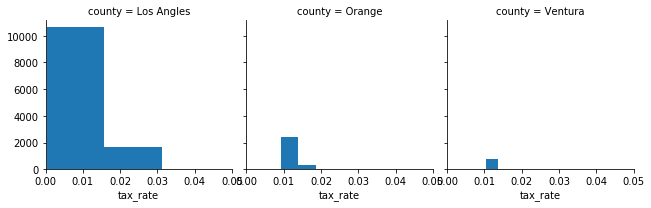

In [46]:
from matplotlib import pyplot as plt

g = sns.FacetGrid(df_tax, col = "county")
g.map(plt.hist, "tax_rate")
plt.xlim(0,.05)
#plt.xticks(np.arange(0, .07, step=0.01))

plt.show()

In [ ]:
## Los Angeles county is the bulk of this data. Might as well be a Los Angeles data set.

In [47]:
#Keeps the DB id as the explicit index for this dataframe
df = df.set_index(['id'])
#Post acquire-prep check for nulls.
df = df.dropna()

# 3 SPLIT-SCALE Section

In [48]:
train, test = split_scale.split_my_data(df,train_ratio=.8,seed=123)

In [49]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12826 entries, 52496 to 36411
Data columns (total 4 columns):
bathrooms    12826 non-null float64
bedrooms     12826 non-null float64
sq_ft        12826 non-null float64
tax_value    12826 non-null float64
dtypes: float64(4)
memory usage: 501.0 KB


In [50]:
X_train = train.drop(columns='tax_value')
y_train = train[['tax_value']]
X_test = test.drop(columns='tax_value')
y_test = test[['tax_value']]

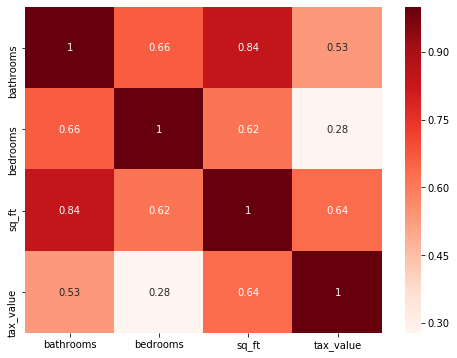

In [51]:
plt.figure(figsize=(8,6))
cor = df.corr()
sns.heatmap(cor,annot=True,cmap=plt.cm.Reds)
plt.show()

### Nothing looks to predictive of tax_value except sq_ft and maybe bathrooms. 

In [34]:
#r2 of 
r2_lm1 = r2_score(y_train,train.yhat)
r2_lm1

0.410221151076836

# 4 Feature Selection

In [35]:
optimal_n_of_features = feature_selection.optimal_number_of_features(X_train, y_train, X_test, y_test)

In [36]:
optimal_n_of_features

2

In [42]:
best_features = feature_selection.optimal_features(X_train, y_train, 2)

In [43]:
best_features

Index(['bathrooms', 'bedrooms'], dtype='object')

In [58]:
#The train DF will have the error scores appended to it as columns.
train['tax_mean'] = train.tax_value.mean()
train['residual'] = train['yhat'] - train['tax_value']
train['residual2'] = train.residual **2

# 5 MODELING AND EVALUATION

In [53]:
#OLS object to analyze features

# ols_model = sm.OLS(y_train,X_train)
# fit = ols_model.fit()
# fit.summary()

ols_model = ols('y_train ~ X_train',data=train).fit()
train['yhat'] = ols_model.predict(y_train)

In [54]:
#r2 of 
r2_lm1 = r2_score(y_train,train.yhat)
r2_lm1

0.410221151076836

In [49]:
lm1 = LinearRegression()

In [50]:
#fit and train model
lm1.fit(X_train,y_train)
lm1_y_intercept = lm1.intercept_
lm1_coefficients = lm1.coef_

#The line-slope measurements of the linear regression model made with what we have selected as 
print('    y-intercept  (b): %.2f' % lm1_y_intercept)
print('    coefficient (m1): %.2f' % lm1_coefficients[0][0])
#print('    coefficient (m2): %.2f' % lm1_coefficients[0][1])

    y-intercept  (b): -34.94
    coefficient (m1): 66.37


In [61]:
y_actual = y_train.tax_value

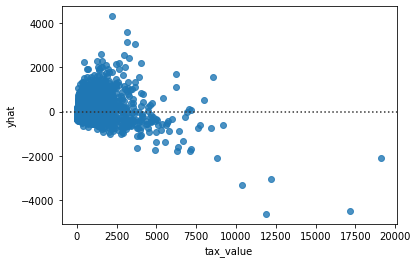

In [62]:
sns.residplot(y_actual,train.yhat)

In [55]:
def get_regression_errors(residuals_squared):
    sse = sum(residuals_squared)
    mse = sse/len(residuals_squared)
    rmse = math.sqrt(mse)
    r2 = ols_model.rsquared
    return sse,mse,rmse,r2

In [59]:
sse, mse, rmse,r2 = get_regression_errors(train.residual2)

In [57]:
print('    SSE : %.2f' % sse)
print('    MSE : %.2f' % mse)
print('    RMSE : %.2f' % rmse)
print('    r2 : %.2f' % r2)

    SSE : 3004639254.96
    MSE : 234261.60
    RMSE : 484.01
    r2 : 0.41


Text(0.5, 1, 'Predicted vs Actual Tax Value')

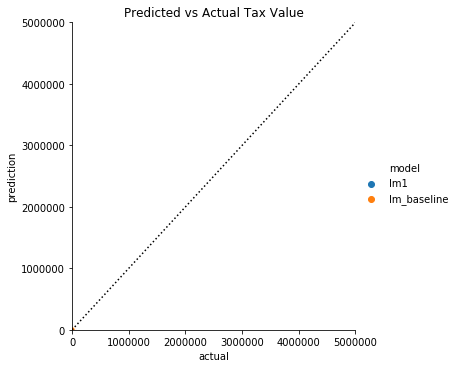

In [64]:
pd.DataFrame({'actual': y_actual,
              'lm1': train.yhat.ravel(),
              'lm_baseline': train.tax_mean.ravel()})\
.melt(id_vars=['actual'], var_name='model', value_name='prediction')\
.pipe((sns.relplot, 'data'), x='actual', y='prediction', hue='model')

min, max = 0, 5_000_000
plt.plot([min, max], [min, max], c='black', ls=':')
plt.ylim(min, max)
plt.xlim(min, max)
plt.title('Predicted vs Actual Tax Value')